In [1]:
#These are the libraries you can use.  You may add any libraries directy related to threading if this is a direction
#you wish to go (this is not from the course, so it's entirely on you if you wish to use threading).  Any
#further libraries you wish to use you must email me, james@uwaterloo.ca, for permission.

%pip install numpy-financial yfinance pandas numpy matplotlib --quiet
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
import random
from datetime import datetime





[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


## Group Assignment
### Team Number: 18
### Team Member Names: Poneesh Kumar, Ian Leung, Vivaan Goel
### Team Strategy Chosen: Market Beat(Market Beat, Market Meet, Risk-Free)

## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Poneesh, Ian, Vivaan

Poneesh: 
- Implemented key financial indicators including RSI, SMA, and Momentum in the assignment notebook.
- Improved the data pipeline, handling data cleaning, formatting, and ensuring analysis ran smoothly.
- Helped with Git version control, resolving conflicts and keeping the repository organized and up to date.
- Updated and reorganized the main notebook, ensuring all code executed properly from start to finish.
- Supported team members with troubleshooting, especially scoring and git syncing problems.


Ian:
- Setup github repository and explained/helped groupmates with git
- Implemented scoring system (the points, not the scoring1 function)
- Implemented weighting algorithm (weighting, mkt cap mix)
- Made the graphs and explanations for our strategy
- Cleaned code and fixed bugs


Vivaan: 
- filtered through the stocks given all the parameters required by each stock (avg daily vol, market type, valid/listed stock, us/can company)
- created the dataframe with all the filtered stocks
- found three metrics for each of the stocks (beta, price % roc, vol % roc)
- helped with calculating the number of shares for each stock
- calculated final portfolio value and made csv file

## Introduction/ Strategy Explanation:
---

Since we are trading over a very short period of time and are aiming to beat the market, we decided to choose and trade stocks based on indicators that demonstrate recent and significant growth compared to the market.

In particular, we placed heavy importance on momentum trading, using indicators like simple moving averages, relative strength index, and price % rate of change. This is very important as in short periods of time, the momentum (growth direction) of a stock is a strong indicator of how a stock will trend in the near future.

As well, we also factored in metrics like volume and volatility. In particular, we factored in the Volume % rate of change, which we found important as it shows if a stock is being traded more frequently than it usually is. Finally, we used Beta as a volatility indicator as since we are trying to beat the market, using beta, which is relative to the market, would be the best way to see if stocks are able to actually beat the market.

One more thing, we chose to pick only 10 stocks as since we are trying to beat the market, diversification will limit growth and choosing only the best stocks will allow for optimal results.

To show proof of our strategy, I will use Nvidia as an example stock

In [2]:
# Calculations are done on two weeks of NVDA data, and results are shown on the next week
start_date = "2025-04-28"
mid_date = "2025-05-09"
end_date = "2025-05-16"

nvda_history_before = yf.Ticker("NVDA").history(start=start_date, end=mid_date)
nvda_history_after = yf.Ticker("NVDA").history(start=mid_date, end=end_date)

nvda_history_before.index = pd.to_datetime(nvda_history_before.index)
nvda_history_before.index = nvda_history_before.index.strftime('%Y-%m-%d')
nvda_history_after.index = pd.to_datetime(nvda_history_after.index)
nvda_history_after.index = nvda_history_after.index.strftime('%Y-%m-%d')

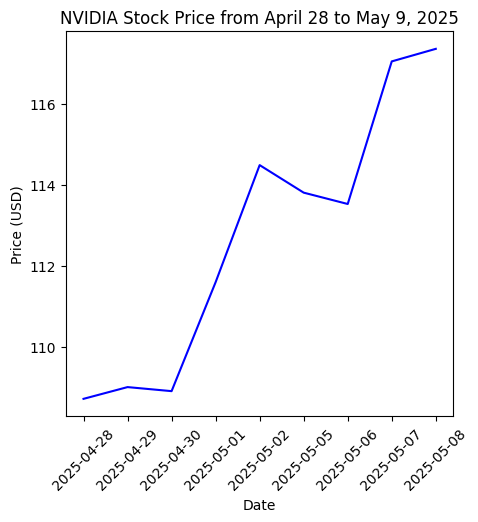

In [3]:
plt.figure(figsize=(5,5))

plt.plot(nvda_history_before.index, nvda_history_before['Close'], label='NVIDIA Price', color='blue')
plt.title('NVIDIA Stock Price from April 28 to May 9, 2025')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.show()

From this, we can already see how NVIDIA is on an upward trend. But I will do the actual calculations to show this.

In [4]:
# SMA
sma = nvda_history_before['Close'].mean()
last_close = nvda_history_before['Close'].iloc[-1]
sma_trend = ((sma - last_close) / last_close) * 100

#Calculate the RSI
delta = nvda_history_before['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.mean()
avg_loss = loss.mean()
rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))

# Price ROC
price_roc = nvda_history_before['Close'].pct_change().mean() * 100

# Volume ROC
volume_roc = nvda_history_before['Volume'].pct_change().mean() * 100

# Beta
nvda_beta = yf.Ticker("NVDA").info['beta']

print(f"SMA Trend: {sma_trend:.2f}%")
print(f"RSI: {rsi:.2f}")
print(f"Price ROC: {price_roc:.2f}%")
print(f"Volume ROC: {volume_roc:.2f}%")
print(f"Beta: {nvda_beta:.2f}")

SMA Trend: -3.95%
RSI: 90.15
Price ROC: 0.97%
Volume ROC: 2.05%
Beta: 2.27


We can see here how the values are heavily indicative of strong upward momentum (negative SMA trend is good, in our strategy), and overall shows up as a very good stock for our strategy. In fact, these values would give us a score of 791.4/1000 in our algorithm, which puts it among the top stocks that we calculated later in this notebook. 

Now, lets see how the subsequent week of this NVIDIA stock went.

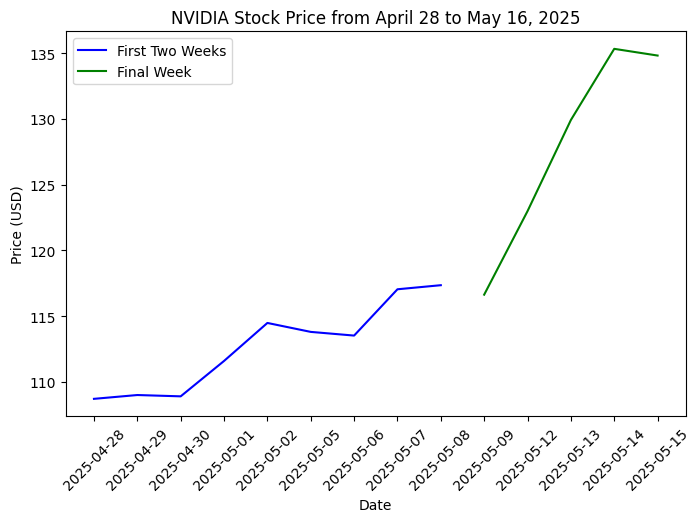

In [5]:
plt.figure(figsize=(8,5))

plt.plot(nvda_history_before.index, nvda_history_before['Close'], label='First Two Weeks', color='blue')
plt.plot(nvda_history_after.index, nvda_history_after['Close'], label='Final Week', color='green')
plt.title('NVIDIA Stock Price from April 28 to May 16, 2025')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.show()

So, we can see here how the 'positive' values that we used over the first two weeks was a strong indicator for future growth (The gap is the weekend). Now, we will implement this strategy for the actual list of stocks.

## Strategy Implementation
---

First, read the tickers from the given csv

In [6]:
filename = "Tickers_Example.csv"
tickers = pd.read_csv(filename, header=None, names=['Ticker'])
tickers.head()

,Ticker
0,AAPL
1,ABBV
2,ABT
3,ACN
4,AGN


Function to find daily volumes for the stocks

In [7]:
history = {}

def averageDailyVolume(ticker):
    start_date = "2024-10-01"
    end_date = "2025-09-30"

    history[ticker.ticker] = ticker.history(start=start_date, end=end_date)

    daily_volume = history[ticker.ticker]['Volume']
    daily_volume.index = daily_volume.index.tz_localize(None)

    # Create a seperate volume dataframe indexed by month
    volume_df = daily_volume.to_frame()
    volume_df['Months'] = volume_df.index.to_period('M')

    # Make it so that the daily volume is in the right time format 
    daily_volume.index = pd.to_datetime(daily_volume.index)
    daily_volume.index = daily_volume.index.strftime('%Y-%m-%d') 
    volume_df.index = pd.to_datetime(volume_df.index)
    volume_df.index = volume_df.index.strftime('%Y-%m-%d') 

    # Assigning the monthly counts for the volume by the months and volume in the df
    monthly_counts = volume_df.groupby('Months')['Volume'].count()
    valid_months = monthly_counts[monthly_counts >= 18].index
    valid_vol_df = volume_df[volume_df['Months'].isin(valid_months)]
    
    # Creating an empty list called volumes to append the volumes of each stock into
    volumes = []
    for volume in valid_vol_df['Volume']:
        volumes.append(volume)
    
    #Compute the average daily volume as the mean of the list
    average_daily_vol = np.mean(volumes)
    return average_daily_vol
    



A scoring function is created to measure a stock’s short-term momentum and strength. Using data between Day 1 and Day 15:
- Price rate of change (ROC)
- Volume ROC
- RSI (Relative Strength Index)
- 7-day SMA and SMA trend strength

These are optimal techincal indicators for momentum trading which is essential for attempting to beat the market over a short period

In [8]:
# Assign day 1 and day 15 of our period for our trading algorithim (Momentum Trading)
day1 = "2025-11-06"
day15 = "2025-11-21"

# Function to calculate financial indicators for scoring
def scoring1(ticker):
    # Assign the start day and end day as date 1 and day 15
    start_date = day1
    end_date = day15

    history[ticker.ticker] = ticker.history(start=start_date, end=end_date)
    daily_close = history[ticker.ticker]['Close']
    daily_volume = history[ticker.ticker]['Volume']
    
    # Localize the close and volume
    daily_close.index = daily_close.index.tz_localize(None)
    daily_volume.index = daily_volume.index.tz_localize(None)

    # Index the daily close and volume to date time
    daily_close.index = pd.to_datetime(daily_close.index)
    daily_close.index = daily_close.index.strftime('%Y-%m-%d') 
    daily_volume.index = pd.to_datetime(daily_volume.index)
    daily_volume.index = daily_volume.index.strftime('%Y-%m-%d') 

    price_change = daily_close.pct_change()
    price_change.drop(index=price_change.index[0], inplace=True)
    volume_change = daily_volume.pct_change()
    volume_change.drop(index=volume_change.index[0], inplace=True)
    
    # Average price and volume roc is the mean *100
    avg_price_roc = np.mean(price_change)*100
    avg_vol_roc = np.mean(volume_change)*100

    #Calculate the RSI
    delta = daily_close.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    # Rolling averages over 7 days
    window = 7
    avg_gain = gain.rolling(window=window, min_periods=window).mean()
    avg_loss = loss.rolling(window=window, min_periods=window).mean()

    # RSI = 100 - (100 / (1 + avgain/avgloss))
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    latest_rsi = rsi.iloc[-1]

    # SMA
    sma_7 = daily_close.rolling(window=7).mean().iloc[-1]

    # Last closing price
    last_close = daily_close.iloc[-1].round(2)

    # SMA trend compares last closing price to SMA
    sma_trend_strength = ((sma_7 - last_close)/ last_close) * 100
    

    return avg_price_roc, avg_vol_roc, latest_rsi, sma_7, sma_trend_strength

We build a master DataFrame (`tickers_df`) containing all essential metrics for each stock:
- Company fundamentals (sector, market cap, beta, country)
- Liquidity measures (average daily volume)
- Momentum indicators (ROC, RSI, SMA, SMA Trend)

This will be used for filtering, scoring, and portfolio construction.

In [9]:
# Make tickers_df all of the info we have so far on the tickers
tickers_df = pd.DataFrame(columns=[
    'Ticker', 'Sector', 'Market Cap', 'Country', 'Market',
    'Avg Daily Vol', 'Beta',
    'Price % ROC', 'Vol % ROC',
    'RSI', 'SMA', 'SMA Trend'
])

# counter for df rows
row = 0
for ticker_sym in tickers['Ticker']:
    ticker = yf.Ticker(ticker_sym)
    # Catch invalid tickers (exceptions)
    try:
        # Assign the metrics and output the data from the scoring function
        price_roc, vol_roc, rsi_val, sma_val, sma_trend = scoring1(ticker)
        tickers_df.loc[row] = {
        'Ticker': ticker_sym,
        'Sector': ticker.info['sector'],
        'Market Cap': ticker.info['marketCap'],
        'Country': ticker.info['country'],
        'Market': ticker.info['market'],
        'Avg Daily Vol': averageDailyVolume(ticker),
        'Beta': ticker.info['beta'],
        'Price % ROC': price_roc.round(3),
        'Vol % ROC': vol_roc.round(3),
        'RSI': rsi_val.round(3),
        'SMA': sma_val.round(3),
        'SMA Trend': sma_trend.round(3)
        }
        row+= 1
    except:
        print(f"{ticker_sym} invalid, skipping...")
# Output tickers df
tickers_df.head()

$AGN: possibly delisted; no timezone found


AGN invalid, skipping...


$CELG: possibly delisted; no timezone found


CELG invalid, skipping...


$MON: possibly delisted; no timezone found


MON invalid, skipping...


$RTN: possibly delisted; no timezone found


RTN invalid, skipping...


,Ticker,Sector,Market Cap,Country,Market,Avg Daily Vol,Beta,Price % ROC,Vol % ROC,RSI,SMA,SMA Trend
0,AAPL,Technology,4029017227264,United States,us_market,5.384430e+07,1.109,-0.117,-0.722,9.964,269.791,1.330
1,ABBV,Healthcare,417597620224,United States,us_market,6.362559e+06,0.352,0.476,0.835,64.024,232.587,1.367
2,ABT,Healthcare,222970200064,United States,us_market,6.189108e+06,0.719,-0.070,11.611,35.162,128.403,3.576
3,ACN,Technology,156865445888,Ireland,us_market,3.444719e+06,1.262,-0.017,0.308,43.656,243.216,1.007
4,AIG,Financial Services,42082131968,United States,us_market,4.416646e+06,0.622,-0.070,-0.046,46.217,77.010,1.744


We filter the dataset according to the rules:
- Only U.S. and Canadian stocks
- Only U.S. or Canadian markets
- Only stocks with average daily volume > 5,000

In [10]:
# Make filtered according to metrics needed such as average daily volume country market etc
filtered_df = tickers_df[(tickers_df["Country"] == 'Canada') | (tickers_df["Country"] == "United States")].reset_index(drop=True)
filtered_df = filtered_df[(filtered_df["Market"] == 'ca_market') | (filtered_df["Market"] == "us_market")].reset_index(drop=True)
filtered_df = filtered_df[filtered_df["Avg Daily Vol"] > 5000].reset_index(drop=True)
filtered_df.head()

,Ticker,Sector,Market Cap,Country,Market,Avg Daily Vol,Beta,Price % ROC,Vol % ROC,RSI,SMA,SMA Trend
0,AAPL,Technology,4029017227264,United States,us_market,5.384430e+07,1.109,-0.117,-0.722,9.964,269.791,1.330
1,ABBV,Healthcare,417597620224,United States,us_market,6.362559e+06,0.352,0.476,0.835,64.024,232.587,1.367
2,ABT,Healthcare,222970200064,United States,us_market,6.189108e+06,0.719,-0.070,11.611,35.162,128.403,3.576
3,AIG,Financial Services,42082131968,United States,us_market,4.416646e+06,0.622,-0.070,-0.046,46.217,77.010,1.744
4,AMZN,Consumer Cyclical,2359223910400,United States,us_market,4.246964e+07,1.368,-1.105,4.071,0.434,230.246,6.036


A scoring function ranks each stock using weighted indicators:
- High weight on price momentum (75%)
- Medium weight on volume momentum (20%)
- Low weight on volatility (5%)

In [11]:
# Points scoring function
def get_score(ticker_df):
    ticker_df['Score'] = (
        # 1: Momentum (75%) since momentum
        350 * bounded_score(ticker_df['Price % ROC'], 0, 1.2) +
        250 * bounded_score(ticker_df['RSI'], 40, 80) +
        150 * bounded_score(ticker_df['SMA Trend'], 0.5, -2) + 
        
        # 2: Volume (20%) 
        200 * bounded_score(ticker_df['Vol % ROC'], 0, 7) + 

        # 3: Volatility (5%) 
        50 * bounded_score(ticker_df['Beta'], 0.5, 1.5)
        )

# Score is calculated linearly between min and max values
def bounded_score(col, min, max):
    return np.round(np.clip((col - min) / (max - min), 0, 1), 3)

Scores are added to the filtered dataframe and sorted for weight calculation 

In [12]:
get_score(filtered_df)
filtered_df = filtered_df.sort_values(by='Score', ascending=False).reset_index(drop=True)
filtered_df.head()

,Ticker,Sector,Market Cap,Country,Market,Avg Daily Vol,Beta,Price % ROC,Vol % ROC,RSI,SMA,SMA Trend,Score
0,MRK,Healthcare,244183302144,United States,us_market,1.396483e+07,0.319,1.039,9.919,78.390,93.801,-1.230,846.90
1,LLY,Healthcare,949975187456,United States,us_market,3.976943e+06,0.389,1.105,-4.412,86.970,1029.654,-1.307,680.80
2,BIIB,Healthcare,25716908032,United States,us_market,1.555065e+06,0.145,0.716,3.566,76.671,166.197,-1.179,640.80
3,LMT,Industrials,107576025088,United States,us_market,1.515056e+06,0.234,-0.006,9.149,71.073,466.047,-0.473,452.60
4,RY.TO,Financial Services,298110615552,Canada,ca_market,4.253649e+06,1.008,0.135,4.366,56.625,207.410,-0.274,340.25


Tier-Based Portfolio Construction:
- 4 stocks at 15%
- 2 stocks at 10%
- 4 stocks at 5%


The algorithm:
- Iterates through the sorted list
- Assigns each stock to the highest available tier
- Ensures sector limits are not exceeded  

This creates a momentum-optimized yet diversified portfolio of 10 stocks that best fit our strategy

In [13]:
# Create a function that finds the tier that each stock is in
def find_tier(tiers):
    # return the first tier index where the count (tier[0]) is > 0
    for i, tier in enumerate(tiers):
        if tier[0] > 0:
            return i
    # fallback if no tier met the condition
    return False

def find_percent_tier(percent):
    # simple allocation policy for additional tickers
    if percent <= 5:
        return 2
    elif percent <= 10:
        return 1
    return 0

def make_portfolio(df):
    portfolio = {}
    industry_set = {}

    # Tiers:
    # 4 stocks at 15%
    # 2 stocks at 10%
    # 4 stocks at 5%
    tiers = [(4, 15), (2, 10), (4, 5)]

    for _, row in df.iterrows():

        # Find available tiers, break when portfolio is full
        tier = find_tier(tiers)
        if tier is False:
            break
        percent = tiers[tier][1]

        # Store industry percentages
        if row["Sector"] not in industry_set:
            portfolio[row["Ticker"]] = percent
            industry_set[row["Sector"]] = percent
            tiers[tier] = (tiers[tier][0] - 1, tiers[tier][1])

        else:
            industry_cap = 40 - industry_set[row["Sector"]]
            if industry_cap <= 0:
                    continue
            if percent > industry_cap:
                percent = industry_cap
                tier = find_percent_tier(percent)
            portfolio[row["Ticker"]] = percent
            industry_set[row["Sector"]] += percent
            tiers[tier] = (tiers[tier][0] - 1, tiers[tier][1])


    return portfolio, industry_set
        

In [14]:
portfolio, industries = make_portfolio(filtered_df)
print(portfolio)
print(industries)

{'MRK': 15, 'LLY': 15, 'BIIB': 10, 'LMT': 15, 'RY.TO': 15, 'PEP': 10, 'CAT': 5, 'BLK': 5, 'PYPL': 5, 'C': 5}
{'Healthcare': 40, 'Industrials': 20, 'Financial Services': 30, 'Consumer Defensive': 10}


Market Cap Mix: Ensures there is at least one large and one small market cap stock

In [15]:
def mkt_cap_mix(df, port, industries):
    # Checking market caps
    large_cap = False
    small_cap = False
    for key in port:
        if df[df['Ticker'] == key]['Market Cap'].values[0] > 10000000000:
            large_cap = True
        elif df[df['Ticker'] == key]['Market Cap'].values[0] < 2000000000:
            small_cap = True
    if large_cap and small_cap:
        return port, industries
    
    # Adding the needed stocks
    small = None
    large = None
    for _, row in df.iterrows():
        if large_cap and row['Market Cap'] < 2000000000:
            port[row['Ticker']] = 5
            industries[row['Sector']] += 5
            large = row['Ticker']
            break
        elif small_cap and row['Market Cap'] > 10000000000:
            port[row['Ticker']] = 5
            industries[row['Sector']] += 5
            small = row['Ticker']
            break
    
    # Ensuring all industries are below 40% weighting
    for ind, weight in industries.items():
        if weight > 40:
            for key in port:
                if df[df['Ticker'] == key]['Sector'].values[0] == ind:
                    if key == small or key == large:
                        continue
                    else:
                        del port[key]
                        industries[ind] -= weight
                        break

    # Ensuring total weight is below 100%
    total_weight = sum(port.values())
    for key in port:
        if total_weight > 100:
            if port[key] == 5 and key != small and key != large:
                port[key] = 0
                total_weight -= 5
        else:
            break             
    return port, industries

portfolio, industries = mkt_cap_mix(filtered_df, portfolio, industries)
print(portfolio)
print(industries)

{'MRK': 15, 'LLY': 15, 'BIIB': 10, 'LMT': 15, 'RY.TO': 15, 'PEP': 10, 'CAT': 5, 'BLK': 5, 'PYPL': 5, 'C': 5}
{'Healthcare': 40, 'Industrials': 20, 'Financial Services': 30, 'Consumer Defensive': 10}


Portfolio Pricing, Currency Conversion, and Shares Allocation
1) Convert USD share prices to CAD
2) Allocate capital according to portfolio weights
3) Compute the number of shares for each position  
A brokerage fee rule is applied, adjusting the portfolio capital before allocation.  
The result shows shares, weights, and CAD value per stock.

In [ ]:
# Assign the start and end date
start_date = day1
end_date = day15

# call the exchange rate 
fx_rate = float(yf.Ticker("CAD=X").history(start=start_date, end=end_date)["Close"].iloc[-1])
portfolio_capital = 1_000_000-(2.15*fx_rate)

# Make an empty list and assign the stock value to 0
records = []
total_stock_value = 0

# For loop for ticker and weight iterating through the portfolio items
for ticker, weight in portfolio.items():

    t = yf.Ticker(ticker)
    hist = t.history(start=start_date, end=end_date)
    last_close = hist["Close"].iloc[-1]
    currency = t.info.get("currency", "USD")

    # Convert price to CAD
    if currency == "USD":
        price_cad = last_close * fx_rate
    else:
        price_cad = last_close

    # Allocate the capital to each stock
    allocation = portfolio_capital * (weight / 100)
    shares = allocation / price_cad
    total_stock_value += price_cad*shares
    value_cad = shares * price_cad

    # Append the info gathered into records
    records.append({
        "Ticker": ticker,
        "Price (CAD)": price_cad,
        "Currency": currency,
        "Shares": shares, 
        "Value (CAD)": value_cad,                     
        "Weight (%)": weight
    })

# Convert to DF for fee calculation
Portfolio_Final = pd.DataFrame(records)


# Apply portfolio-level fee rule
total_shares = Portfolio_Final["Shares"].sum()
# If total shares > 2150 apply base fee if not use the 0.001 usd fee
if total_shares > 2150:
    total_fee_usd = 2.15
else:
    total_fee_usd = total_shares * 0.001
# Convert total fees to canadian
total_fee_cad = round(total_fee_usd * fx_rate, 4)

# Round outputs
Portfolio_Final["Shares"] = Portfolio_Final["Shares"].round(4)
Portfolio_Final["Value (CAD)"] = Portfolio_Final["Value (CAD)"].round(2)
Portfolio_Final["Price (CAD)"] = Portfolio_Final["Price (CAD)"].round(2)
    
# Sort for clean output
Portfolio_Final = Portfolio_Final.sort_values("Weight (%)", ascending=False).reset_index(drop=True)

Portfolio_Final

,Ticker,Price (CAD),Currency,Shares,Value (CAD),Weight (%)
0,MRK,133.82,USD,1120.8707,149999.55,15
1,LLY,1470.12,USD,102.0321,149999.55,15
2,LMT,659.83,USD,227.3290,149999.55,15
3,RY.TO,207.98,CAD,721.2210,149999.55,15
4,BIIB,236.99,USD,421.9650,99999.70,10
5,PEP,205.87,USD,485.7362,99999.70,10
6,CAT,769.56,USD,64.9718,49999.85,5
7,BLK,1398.58,USD,35.7504,49999.85,5
8,PYPL,81.88,USD,610.6709,49999.85,5
9,C,137.57,USD,363.4439,49999.85,5


We compute the portfolio values to show how much capital is used 

This final check confirms whether the portfolio respects the $1,000,000 constraint and evaluates the financial impact of rounding and fees.


In [17]:
rounded_stock_value = 0
for i in range(len(Portfolio_Final)):
    row = Portfolio_Final.iloc[i]
    rounded_stock_value += row['Value (CAD)']
    
# Find the total and rounded portfolio value of the portfolio
total_portfolio_value = total_fee_cad + total_stock_value
rounded_portfolio_value = total_fee_cad + rounded_stock_value
print(f"Rounded Portfolio Value (may exceed $1 million): {rounded_portfolio_value.round(2)}")
print(f"Actual Portfolio Value: {total_portfolio_value.round(2)}")


Rounded Portfolio Value (may exceed $1 million): 1000000.03
Actual Portfolio Value: 1000000.0


CSV Output:
- Assign the stocks to a csv file including the ticker and shares and call it according to our group number

In [ ]:
# Export the stock ticker and shares into a csv file
stocks_csv = Portfolio_Final[["Ticker", "Shares"]]
stocks_csv.to_csv("Stocks_Group_18.csv",index=False)